In [9]:
from scipy import ndimage
from scipy.signal import convolve2d
import numpy as np
from osgeo import gdal

def four_neighbor_average_convolve2d(array, no_data_value = -9999.0):
    """_summary_
    Computes the average of four neighbors of a given array using
    convolve2d in scipy

    Args:
        array (ndarray): Input array for four neighbor average.
        no_data_value (float, optional): Value of NoData in the raster. Defaults to -9999.0.

    Returns:
        ndarray: The 4-N averaged array with the NoData values retained in the same position and replaced with numpy.nan
    """    
    is_valid = (array != no_data_value) & (~np.isnan(array))
    mask = is_valid.astype(float)

    kernel = np.array( [[0,1,0],
                        [1,0,1],
                        [0,1,0]])

    array_clean = np.where(is_valid, array, 0.0)
    neighbor_sum = convolve2d(
        array_clean, kernel, mode='same',
        boundary='fill', fillvalue=0)

    num_neighbor = convolve2d(
        mask, kernel, mode='same', 
        boundary='fill', fillvalue=0)
    
    avg = np.divide(neighbor_sum, num_neighbor, 
                    out=np.full_like(array, np.nan, dtype=float), 
                    where=num_neighbor > 0)

    return np.where(is_valid, avg, np.nan)

def SLBL(dem_array, tol=0.0, maxt=0.0, threshold=0.001, nmax_iter=100, cell_size=1.0):
    """_summary_
    Computes the volume of landslide on a 
    defined area using sloping local base level (SLBL)

    Parameters:
    dem_array (ndarray): The original dem input in an 
                            ndarray format
    tol (float): User-defined (computed) maximum tolerance.
    maxt (float): User-defined (expected) maximum thickness of the landslide.
    threshold (float): User-defined threshold.
    max_iter (int): Maximum iterations allowed. Default = 100
    cell_size (float): The cell (pixel) size of the input DEM. 

    Returns:
    volume (float): The computed landslide volume
    
    """

    # Main SLBL logic
    prev_dem = dem_array.copy()
    iter = 0
    current_threshold = 1000 # Arbitrary amount, so while loop doesn't stop at iter=2

    while iter < 100 and current_threshold > threshold:
        mat_neigh = four_neighbor_average_convolve2d(prev_dem) - tol
        mat_comp = np.fmin(prev_dem, mat_neigh)
        mat_diff = np.where(np.isnan(prev_dem), np.nan, mat_comp - prev_dem)
        current_threshold = np.max(np.abs(mat_diff))
        prev_dem = mat_comp.copy()
        
        # SLBL logic ends
        iter+=1

    # Volume computation
    x = dem_array.copy()
    x[(x == -9999)] = np.nan # Just removing any NoData values in the DEM
    volume = np.nansum(np.subtract(x, prev_dem)) * cell_size * cell_size

    return volume


ds = gdal.Open('/home/richmond/Downloads/test_clipped.tif')
array = ds.GetRasterBand(1).ReadAsArray(0)

In [8]:
volume = four_neighbor_average_convolve2d(array)
print(volume)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


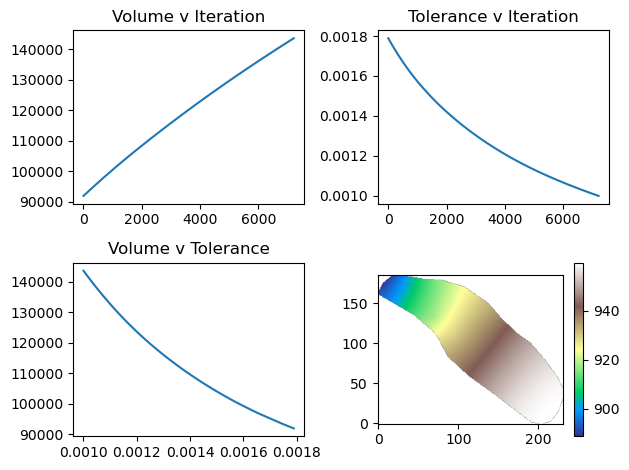

In [70]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2,2)

ax[0,0].plot(
    vol_list[4999:],
)

ax[0,1].plot(
    tol_list[4999:],
)

ax[1,0].plot(
    tol_list[4999:],
    vol_list[4999:],
    
)

terrain = ax[1,1].imshow(x, 
               cmap= plt.cm.terrain.copy(),
               origin='lower')

ax[0,0].set_title("Volume v Iteration")
ax[0,1].set_title("Tolerance v Iteration")
ax[1,0].set_title('Volume v Tolerance')
fig.colorbar(terrain, ax = ax[1,1])
fig.tight_layout()

plt.show()